In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import math
import time

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.lin as lin
import models.rf as rf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def write_metrics(y_test, y_predict):
    print(' ')
    print('The mean squared error is:',mean_squared_error(y_test, y_predict))
    print('The root mean squared error is:',math.sqrt(mean_squared_error(y_test, y_predict)))
    print('The mean absolute error:',mean_absolute_error(y_test,y_predict))
    print(' ')

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    #print(y_test.iloc[shot_index])
    #print(y_test.iloc[shot_index])
    id_value=y_test.iloc[shot_index].name
    #print(df_time_clean.loc[id_value])
    #print(y_test_reset.loc[shot_index])
    #print(df_input_clean.loc[id_value])
    return(df_input['shot number'].loc[id_value])

# Read the dataset

In [4]:
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)


Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [5]:
#Get the clean shots
#df_input_clean,df_time_clean,df_freq_int_clean=clean_shots(df_input,df_time,df_freq_int)
minval=8000
df_input_clean,df_time_clean,df_freq_int_clean=data_analysis.clean_shots_below(minval,df_input,df_time,df_freq_int)


Shots with max val below this will be discarded: 8000



### Define the inputs and targets

In [6]:
#define input and output for the model

#In this notebook, the two models (forward and backward) are trained.
#we keep the same X and y. Note that in the backward model the X  and y need to be switched.

X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_clean,df_time_clean,rand_split=False)

In [7]:
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

## Train the roundtrip linear model

In [8]:
lin_model_forward, lin_model_backward=models_tools.train_roundtrip_lin(X_train, X_test, y_train, y_test)
y_predict_lin_roundtrip=models_tools.roundtrip_lin_predict(y_test,lin_model_backward,lin_model_forward)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Train the backward RF model

In [9]:
#train backward model with RF
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18
rf_model_backward=rf.fit_random_forest(y_train,X_train,n_estimators, max_features,max_depth, random_state)

In [10]:
X_predict_rf_backward=rf.make_rf_prediction(rf_model_backward,y_test)

## Train the roundtrip RF model

In [11]:
#train forward model with Random forest
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

#train roadtrip model
rf_model_forward,rf_model_backward = models_tools.train_roundtrip_rf(X_train, X_test, y_train, y_test,
                                                            n_estimators, max_features,max_depth, random_state)
#roundtrip prediction
y_predict_rf_roundtrip=models_tools.roundtrip_rf_predict(y_test,rf_model_backward,rf_model_forward)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Train the roundtrip model with a FCNN (RF used in the forward phase)

In [12]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


We are using: cpu


In [13]:
#hyperparameters
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

rf_model_forward,fcnn_model_backward=models_tools.train_roundtrip_fcnn(X_train, X_test, y_train, y_test,
                         n_estimators, max_features,max_depth, random_state,
                         n_epochs,batch_size,print_freq,learning_rate)
y_predict_fcnn_roundtrip=models_tools.roundtrip_fcnn_predict(y_test,X_train,fcnn_model_backward,rf_model_forward,device)

We are using: cpu
Finished epoch 0,latest loss 0.8257415294647217
Finished epoch 10,latest loss 0.4666939377784729
Finished epoch 20,latest loss 0.33075159788131714
Finished epoch 30,latest loss 0.2965701222419739
Finished epoch 40,latest loss 0.28354179859161377
Finished epoch 50,latest loss 0.2726970314979553
Finished epoch 60,latest loss 0.26186785101890564
Finished epoch 70,latest loss 0.2518567144870758
Finished epoch 80,latest loss 0.24294032156467438
Finished epoch 90,latest loss 0.2378062754869461
Finished epoch 100,latest loss 0.23192737996578217
Finished epoch 110,latest loss 0.22847959399223328
Finished epoch 120,latest loss 0.2246566265821457
Finished epoch 130,latest loss 0.22074928879737854
Finished epoch 140,latest loss 0.2175443321466446
Finished epoch 150,latest loss 0.2149626463651657
Finished epoch 160,latest loss 0.21147823333740234
Finished epoch 170,latest loss 0.20747891068458557
Finished epoch 180,latest loss 0.20435191690921783
Finished epoch 190,latest loss 0.

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Train roundtrip model with CNN (forward phase is RF)

In [14]:
#hyperparameters
n_epochs=100
batch_size=20
print_freq=10
learning_rate=0.001

rf_model_forward,cnn_model_backward=models_tools.train_roundtrip_cnn(X_train, X_test, y_train, y_test,
                         n_estimators, max_features,max_depth, random_state,
                         n_epochs,batch_size,print_freq,learning_rate)
y_predict_cnn_roundtrip=models_tools.roundtrip_cnn_predict(y_test,X_train,cnn_model_backward,rf_model_forward,device)

We are using: cpu
Finished epoch 0,latest loss 0.8384036421775818
Finished epoch 10,latest loss 0.45746153593063354
Finished epoch 20,latest loss 0.39466023445129395
Finished epoch 30,latest loss 0.33067381381988525
Finished epoch 40,latest loss 0.2808391749858856
Finished epoch 50,latest loss 0.2592758238315582
Finished epoch 60,latest loss 0.24562296271324158
Finished epoch 70,latest loss 0.2351006269454956
Finished epoch 80,latest loss 0.22400838136672974
Finished epoch 90,latest loss 0.21643324196338654
Finished epoch 99,latest loss 0.210505872964859
Total time taken to train the model: 218.07s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Plot some examples

In [15]:
#linear model
#y_predict_lin_backforw=lin_model_forward.predict(X_predict_lin_backward)
#random forest
#y_predict_backforw=forest_regr_forward.predict(X_predict_forest_backward)
#FC NN (using RF as forward)
#y_predict_fcnn_backforw=forest_regr_forward.predict(X_predict_fc_nn)
#CNN (using RF as forward
#y_predict_cnn_backforw=forest_regr_forward.predict(X_predict_cnn)

In [16]:
def plot_example(shot_index,y_test,y_test_reset,df_input_clean,df_time_val,
                 y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input_clean)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
    plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_backforw[shot_index],label='Prediction (Random  forest)')
    plt.plot(df_time_val,y_predict_fcnn_backforw[shot_index],label='Prediction (FC NN)')
    plt.plot(df_time_val,y_predict_cnn_backforw[shot_index],label='Prediction (CNN)')

    mae='{:6.5f}'.format(mean_absolute_error(y_test_reset.loc[shot_index],y_predict_lin_backforw[shot_index]))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

In [17]:
def plot_example_2(shot_index,y_test,y_test_reset,df_input_clean,df_time_val,
                 y_predict,X_predict):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input_clean)

    #print the predicted and real input parameteres:
    #print(X_predict[shot_index])
    #print(df_input_clean[df_input_clean['shot number']==shot_numb])
    
    o2_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order2']
    o3_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order3']
    o4_real=df_input_clean[df_input_clean['shot number']==shot_numb]['order4']
    
    min_order2=df_input_clean['order2'].min()
    max_order2=df_input_clean['order2'].max()

    min_order3=df_input_clean['order3'].min()
    max_order3=df_input_clean['order3'].max()

    min_order4=df_input_clean['order4'].min()
    max_order4=df_input_clean['order4'].max()
    #print(min_order2,max_order2)

    
    fig, ax = plt.subplots()
    
    ax.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=5)
    ax.plot(df_time_val,y_predict[shot_index],label='Prediction (Random  forest)',linewidth=5,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=13)

    #Inset plot with the input parameters
    y_temp=[0]
    ax.figure.set_size_inches(9, 6.5)
    widht1d=2.3 #1d plot widht
    height1d=0.8
    bbox_left=140
    
    axin2 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,600])
    axin2.scatter(o2_real,y_temp,100,label='Test')
    axin2.scatter(X_predict[shot_index][0],y_temp,100,label='prediction',marker='s')
    axin2.spines['top'].set_visible(False)
    axin2.spines['right'].set_visible(False)
    axin2.spines['left'].set_visible(False)
    axin2.yaxis.set_visible(False)
    axin2.spines['bottom'].set_position('zero')
    axin2.set_xlabel(r'$\beta^{(2)}$',fontsize=12)
    axin2.set_xlim(min_order2,max_order2)
    axin2.patch.set_alpha(0.0)

    axin3 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,530])
    axin3.scatter(o3_real,y_temp,100,label='Test')
    axin3.scatter(X_predict[shot_index][1],y_temp,100,label='prediction',marker='s')
    axin3.spines['top'].set_visible(False)
    axin3.spines['right'].set_visible(False)
    axin3.spines['left'].set_visible(False)
    axin3.yaxis.set_visible(False)
    axin3.spines['bottom'].set_position('zero')
    axin3.set_xlabel(r'$\beta^{(3)}$',fontsize=12)
    axin3.set_xlim(min_order3,max_order3)
    axin3.patch.set_alpha(0.0)

    axin4 = inset_axes(ax, width=widht1d, height=height1d,loc=2,bbox_to_anchor=[bbox_left,460])
    axin4.scatter(o4_real,y_temp,100,label='Test')
    axin4.scatter(X_predict[shot_index][2],y_temp,100,label='prediction',marker='s')
    axin4.spines['top'].set_visible(False)
    axin4.spines['right'].set_visible(False)
    axin4.spines['left'].set_visible(False)
    axin4.yaxis.set_visible(False)
    axin4.spines['bottom'].set_position('zero')
    axin4.set_xlabel(r'$\beta^{(4)}$',fontsize=12)
    axin4.set_xlim(min_order4,max_order4)
    axin4.patch.set_alpha(0.0)


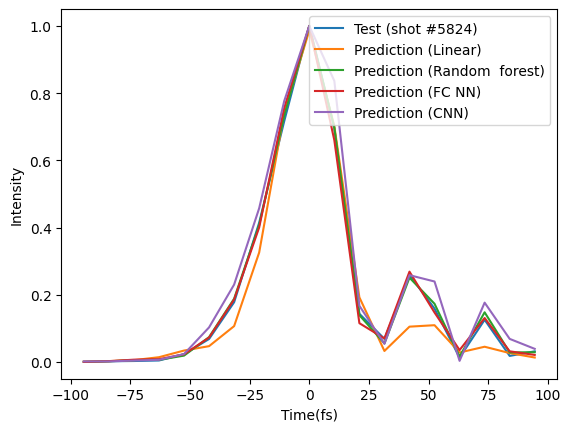

In [18]:
plot_example(225,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_lin_roundtrip,y_predict_rf_roundtrip,y_predict_fcnn_roundtrip,y_predict_cnn_roundtrip)

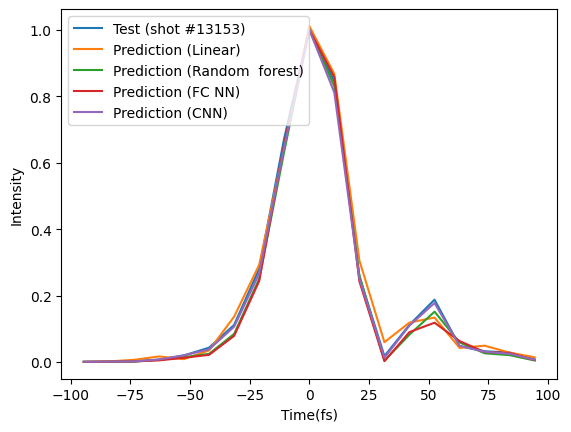

In [19]:
plot_example(238,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_lin_roundtrip,y_predict_rf_roundtrip,y_predict_fcnn_roundtrip,y_predict_cnn_roundtrip)

### plot the same for the paper (including the input parameter predictions)

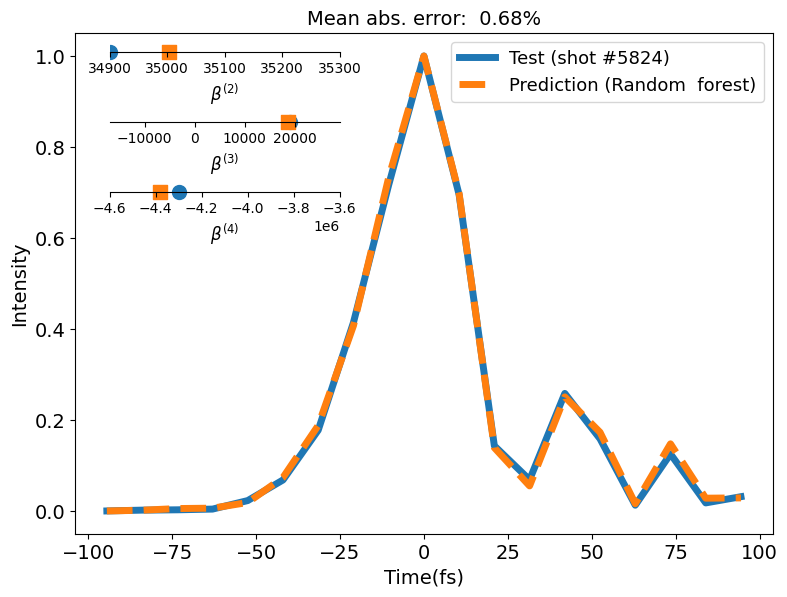

In [20]:
plot_example_2(225,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_rf_roundtrip,X_predict_rf_backward)

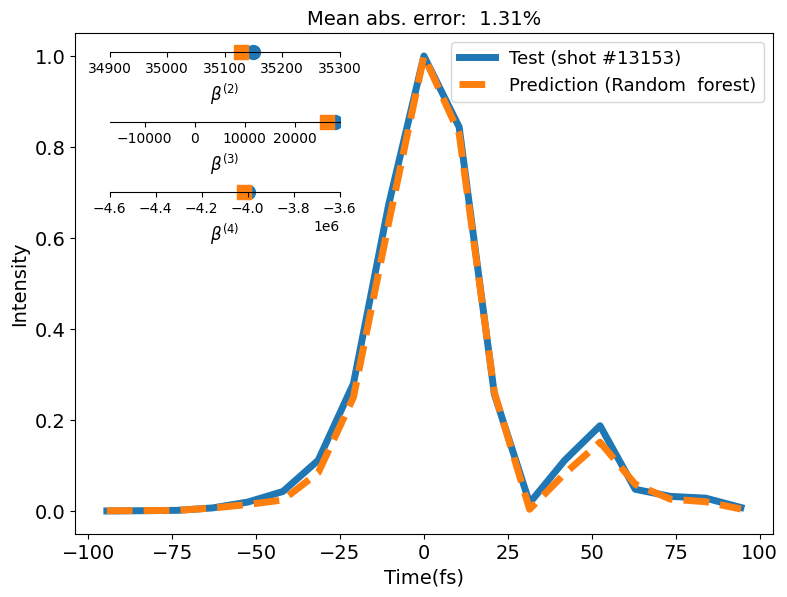

In [21]:
plot_example_2(238,y_test,y_test_reset,df_input_clean,df_time_val,
             y_predict_rf_roundtrip,X_predict_rf_backward)

## Error distribution

### linear model

In [22]:
#study the erro distribution
df_error_backforw_lin=abs(y_test_reset-y_predict_lin_roundtrip)
df_error_backforw_lin=df_error_backforw_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_lin)

print(df_error_backforw_lin.idxmax())
print(df_error_backforw_lin.max())

0       0.036825
1       0.032472
2       0.031236
3       0.014767
4       0.032237
          ...   
3640    0.028932
3641    0.012871
3642    0.023056
3643    0.021987
3644    0.032514
Length: 3645, dtype: float64
3460
0.15687578529522048


### random forest

In [23]:
#study the erro distribution
df_error_backforw_forest=abs(y_test_reset-y_predict_rf_roundtrip)
df_error_backforw_forest=df_error_backforw_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_forest)

print(df_error_backforw_forest.idxmax())
print(df_error_backforw_forest.max())

0       0.010567
1       0.005699
2       0.009925
3       0.007962
4       0.005686
          ...   
3640    0.007758
3641    0.007991
3642    0.009502
3643    0.003357
3644    0.012474
Length: 3645, dtype: float64
1228
0.12746206877206911


### FC NN

In [24]:
#study the erro distribution
df_error_backforw_fcnn=abs(y_test_reset-y_predict_fcnn_roundtrip)
df_error_backforw_fcnn=df_error_backforw_fcnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_fcnn)

print(df_error_backforw_fcnn.idxmax())
print(df_error_backforw_fcnn.max())

0       0.007981
1       0.010518
2       0.010408
3       0.010660
4       0.009576
          ...   
3640    0.010623
3641    0.011690
3642    0.007855
3643    0.007093
3644    0.018379
Length: 3645, dtype: float64
3413
0.1365767646619326


### CNN

In [25]:
#study the erro distribution
df_error_backforw_cnn=abs(y_test_reset-y_predict_cnn_roundtrip)
df_error_backforw_cnn=df_error_backforw_cnn.sum(axis=1)/y_test.shape[1] #sum error / num columns
print(df_error_backforw_cnn)

print(df_error_backforw_cnn.idxmax())
print(df_error_backforw_cnn.max())

0       0.006790
1       0.005102
2       0.003742
3       0.006408
4       0.008329
          ...   
3640    0.006111
3641    0.010261
3642    0.003369
3643    0.008758
3644    0.008232
Length: 3645, dtype: float64
2479
0.12202613464285704


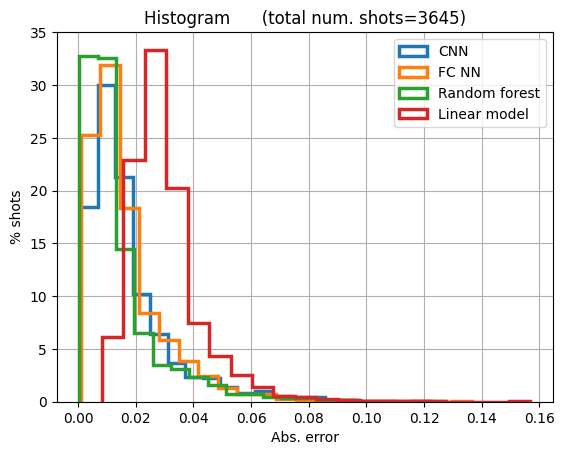

In [26]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
df_error_backforw_cnn.hist(bins=20,weights=weights_backforw_cnn,histtype="step",linewidth=2.5,label='CNN')
df_error_backforw_fcnn.hist(bins=20,weights=weights_backforw_fcnn,histtype="step",linewidth=2.5,label='FC NN')
df_error_backforw_forest.hist(bins=20,weights=weights_backforw_forest,histtype="step",linewidth=2.5,label='Random forest')
df_error_backforw_lin.hist(bins=20,weights=weights_backforw_lin,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(df_error_backforw_forest))+')')
plt.legend()

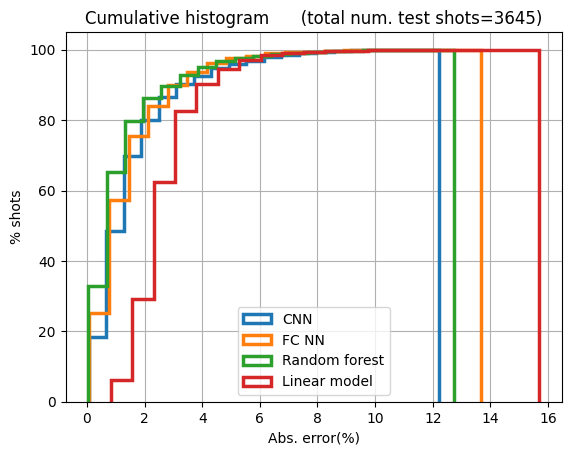

The average error in the CNN is 1.79%
The average error in the FC NN is 1.69%
The average error in the Random forest is 1.44%
The average error in the linear model is 3.01%
 
 


In [27]:
weights_backforw_cnn = 100*np.ones_like(df_error_backforw_cnn) / len(df_error_backforw_cnn)
weights_backforw_fcnn = 100*np.ones_like(df_error_backforw_fcnn) / len(df_error_backforw_fcnn)
weights_backforw_forest = 100*np.ones_like(df_error_backforw_forest) / len(df_error_backforw_forest)
weights_backforw_lin = 100*np.ones_like(df_error_backforw_lin) / len(df_error_backforw_lin)
(100*df_error_backforw_cnn).hist(bins=20,weights=weights_backforw_cnn,cumulative=True,histtype="step",linewidth=2.5,label='CNN')
(100*df_error_backforw_fcnn).hist(bins=20,weights=weights_backforw_fcnn,cumulative=True,histtype="step",linewidth=2.5,label='FC NN')
(100*df_error_backforw_forest).hist(bins=20,weights=weights_backforw_forest,cumulative=True,histtype="step",linewidth=2.5,label='Random forest')
(100*df_error_backforw_lin).hist(bins=20,weights=weights_backforw_lin,cumulative=True,histtype="step",linewidth=2.5, label='Linear model')
plt.ylabel('% shots')
plt.xlabel('Abs. error(%)')
plt.title('Cumulative histogram      (total num. test shots='+str(len(df_error_backforw_forest))+')')
plt.legend()
plt.show()

avg_error_cnn=100*df_error_backforw_cnn.mean()
avg_error_fcnn=100*df_error_backforw_fcnn.mean()
avg_error_forest=100*df_error_backforw_forest.mean()
avg_error_lin=100*df_error_backforw_lin.mean()
print('The average error in the CNN is {:4.2f}%'.format(avg_error_cnn))
print('The average error in the FC NN is {:4.2f}%'.format(avg_error_fcnn))
print('The average error in the Random forest is {:4.2f}%'.format(avg_error_forest))
print('The average error in the linear model is {:4.2f}%'.format(avg_error_lin))
print(' ')
print(' ')

## Error distribution in the parameter space

We want to see if there is any correlation between the largest error shots and its parameters

In [28]:
temp_error_forest=df_error_backforw_forest.copy()
temp_error_forest.to_frame()
temp_error_forest=temp_error_forest.set_axis(y_test.index)
print(temp_error_forest)
df_error_distr=X_test.copy()
df_error_distr['error prediction']=temp_error_forest
df_error_distr=df_error_distr[df_error_distr['error prediction']>0.01]
df_error_distr

23       0.010567
4273     0.005699
1046     0.009925
9925     0.007962
4816     0.005686
           ...   
6828     0.007758
4559     0.007991
4014     0.009502
3894     0.003357
10701    0.012474
Length: 3645, dtype: float64


,order2,order3,order4,error prediction
23,34900,-17000,-3900000.0,0.010567
3798,35000,19000,-4200000.0,0.023112
4087,35000,29000,-4300000.0,0.017652
375,34900,-5000,-3800000.0,0.014314
11575,35300,1000,-3900000.0,0.022268
...,...,...,...,...
4777,35050,5000,-3700000.0,0.013169
6607,35100,21000,-4300000.0,0.022813
2933,35000,-11000,-3800000.0,0.010638
2846,35000,-14000,-3700000.0,0.012395


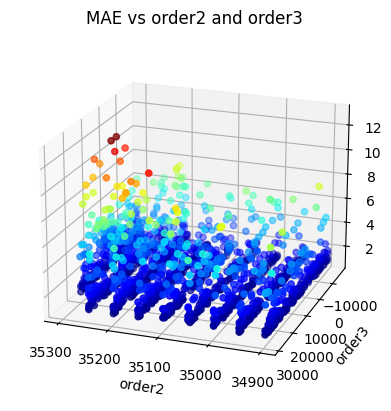

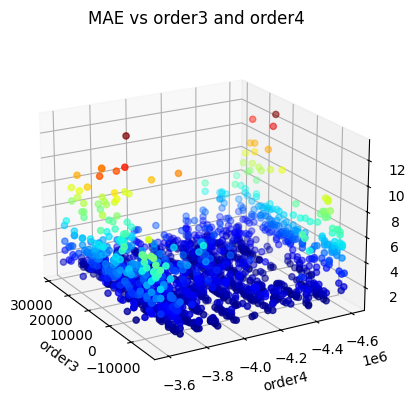

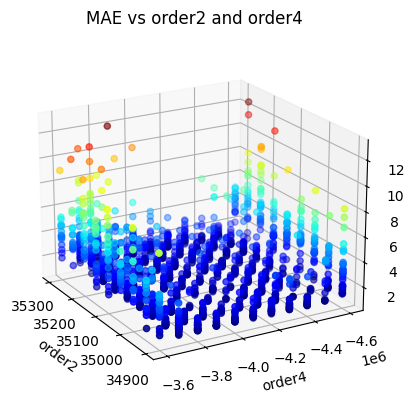

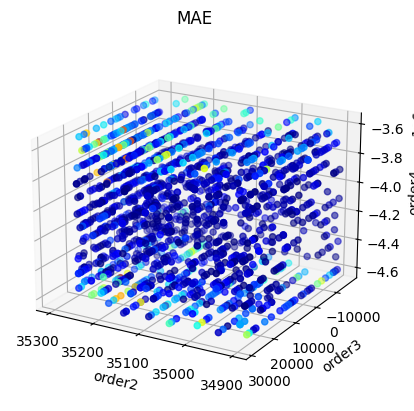

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_error_distr['order2'], df_error_distr['order3'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Error')
ax.view_init(elev=20., azim=110)
plt.title('MAE vs order2 and order3')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_error_distr['order3'], df_error_distr['order4'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Error')
ax2.view_init(elev=20., azim=150)
plt.title('MAE vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_error_distr['order2'], df_error_distr['order4'], 100*df_error_distr['error prediction'],c=100*df_error_distr['error prediction'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Error')
ax3.view_init(elev=20., azim=150)
plt.title('MAE vs order2 and order4')
plt.show()

fig = plt.figure()
ax4 = fig.add_subplot(projection='3d')
ax4.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['order4'],c=100*df_error_distr['error prediction'],cmap='jet')
ax4.set_xlabel('order2')
ax4.set_ylabel('order3')
ax4.set_zlabel('order4')
ax4.view_init(elev=20., azim=120)
plt.title('MAE')
#plt.tight_layout()
plt.show()

## Test shots (Apr 12)

In [30]:
#X are dazzler param, y is intensity

In [40]:
def plot_test_shot_and_predictions(y_test_shot,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device):
    ###  random forest
    #X_predict_shot_forest=forest_regr_backward.predict(y_test_shot) #backward prediction
    #y_predict_shot_forest=forest_regr_forward.predict(X_predict_shot_forest) #forward prediction
    y_predict_shot_forest=models_tools.roundtrip_rf_predict(y_test_shot,rf_model_backward,rf_model_forward)
    #print(y_predict_shot0)

    ###  FCNN
    #first convert to tensor
    #y_test_shot_tensor=torch.tensor(y_test_shot)#.values,dtype=torch.float32)
    #y_test_shot_tensor=y_test_shot_tensor.to(device)
    #X_predict_shot_fcnn_tensor=nn_fc_model(y_test_shot_tensor)
    #X_predict_shot_fcnn_reg=X_predict_shot_fcnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    #X_predict_shot_fcnn=X_predict_shot_fcnn_reg.copy()
    #X_predict_shot_fcnn[:,0]=(X_predict_shot_fcnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    #X_predict_shot_fcnn[:,1]=(X_predict_shot_fcnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    #X_predict_shot_fcnn[:,2]=(X_predict_shot_fcnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    #y_predict_shot_fcnn=forest_regr_forward.predict(X_predict_shot_fcnn) #forward prediction
    y_predict_shot_fcnn=models_tools.roundtrip_fcnn_predict(y_test_shot,X_train,fcnn_model_backward,rf_model_forward,device)
    

    ### CNN
    #X_predict_shot_cnn_tensor=cnn_model(y_test_shot_tensor.unsqueeze(1))
    #X_predict_shot_cnn_reg=X_predict_shot_cnn_tensor.detach().cpu().numpy()
    #Revert the target normalization
    #X_predict_shot_cnn=X_predict_shot_cnn_reg.copy()
    #X_predict_shot_cnn[:,0]=(X_predict_shot_cnn_reg[:,0]*X_train['order2'].std())+X_train['order2'].mean()
    #X_predict_shot_cnn[:,1]=(X_predict_shot_cnn_reg[:,1]*X_train['order3'].std())+X_train['order3'].mean()
    #X_predict_shot_cnn[:,2]=(X_predict_shot_cnn_reg[:,2]*X_train['order4'].std())+X_train['order4'].mean()
    #y_predict_shot_cnn=forest_regr_forward.predict(X_predict_shot_cnn) #forward prediction
    y_predict_shot_cnn=models_tools.roundtrip_cnn_predict(y_test_shot,X_train,cnn_model_backward,rf_model_forward,device)

    plt.plot(df_time_val,y_test_shot.loc[0],label='Test shot')
    plt.plot(df_time_val,y_predict_shot_forest[0],label='Prediction round-trip RF')
    plt.plot(df_time_val,y_predict_shot_fcnn[0],label='Prediction round-trip FC NN')
    plt.plot(df_time_val,y_predict_shot_cnn[0],label='Prediction round-trip CNN')
    mae='{:6.5f}'.format(mean_absolute_error(y_test_shot,y_predict_shot_forest))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

         0        1         2         3         4         5         6   \
0  0.001199  0.00104  0.004285  0.005213  0.026507  0.101424  0.261314   

         7         8    9        10        11        12        13       14  \
0  0.482225  0.783666  1.0  0.82783  0.244637  0.016048  0.241497  0.34343   

         15        16        17        18  
0  0.031268  0.142042  0.087892  0.057908  


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


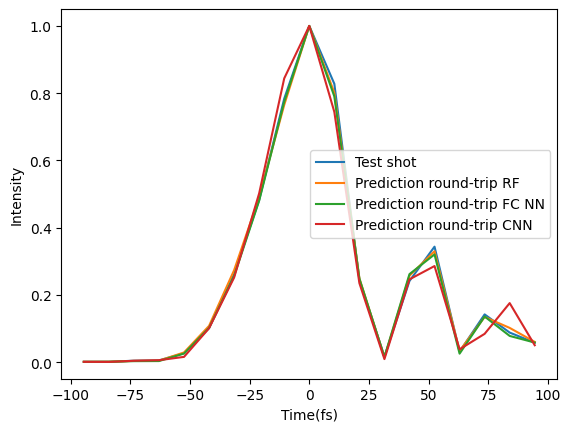

In [41]:
#shot0
y_test_shot0=[[0.001199,0.00104,0.004285,0.005213,0.026507,0.101424,0.261314,0.482225,0.783666,1.0,0.82783,0.244637,0.016048,0.241497,0.34343,0.031268,0.142042,0.087892,0.057908]]
y_test_shot_df=pd.DataFrame(y_test_shot0)
plot_test_shot_and_predictions(y_test_shot_df,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


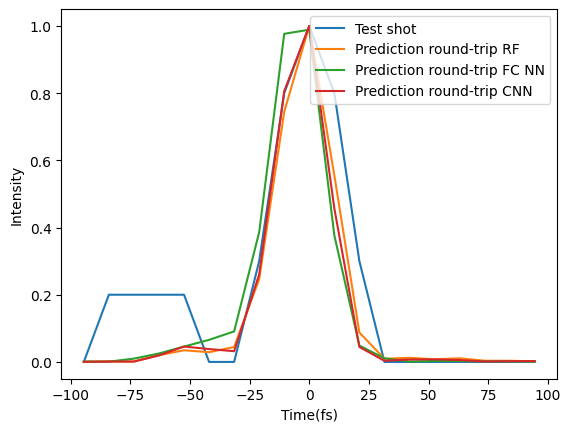

In [43]:
#shot1
y_test_shot1=[[0,0.2,0.2,0.2,0.2,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_test_shot_df=pd.DataFrame(y_test_shot1)
plot_test_shot_and_predictions(y_test_shot_df,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


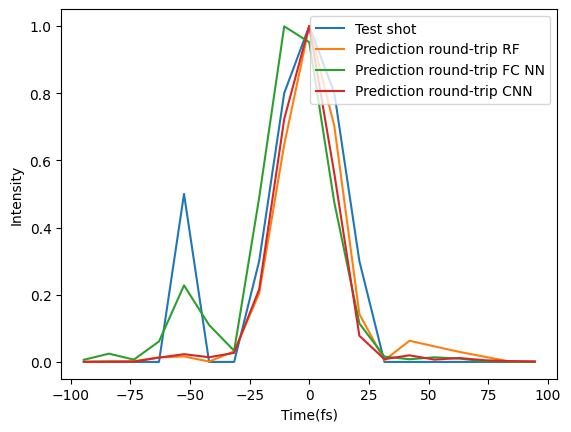

In [44]:
#shot2
y_test_shot2=[[0,0,0,0,0.5,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_test_shot_df=pd.DataFrame(y_test_shot2)
plot_test_shot_and_predictions(y_test_shot_df,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


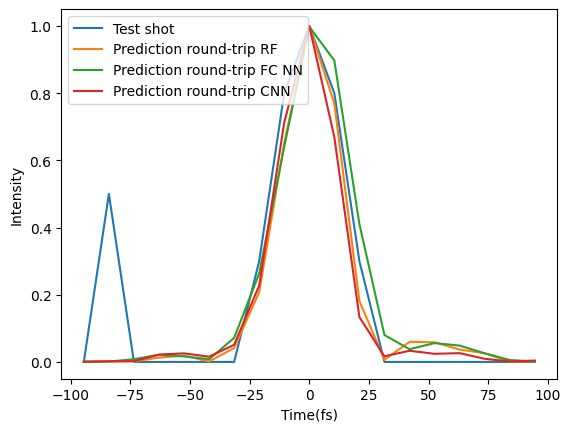

In [45]:
#shot3
y_test_shot3=[[0,0.5,0,0,0,0,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_test_shot_df=pd.DataFrame(y_test_shot3)
plot_test_shot_and_predictions(y_test_shot_df,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


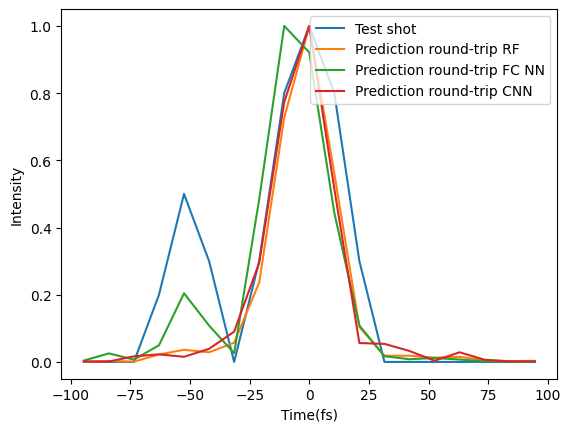

In [46]:
#shot4 (checking myself
y_test_shot4=[[0,0,0,0.2,0.5,0.3,0,0.3,0.8,1,0.8,0.3,0,0,0,0,0,0,0]]
y_test_shot_df=pd.DataFrame(y_test_shot4)
plot_test_shot_and_predictions(y_test_shot_df,X_train,
                                   rf_model_backward,rf_model_forward,
                                  fcnn_model_backward,
                                  cnn_model_backward,device)